__OBJECTIVE__

To train the model to whether the loan should be given or not to prevent default on them


__Understanding Data__

__Loan_ID__: Unique id to distinguish between loans

__Gender__: Male/Female

__Married__: Martial status of the person - Yes/No

__Dependents__: Number of person dependent on person (0/1/2/3+)

__Education__: Graduate/Not Graduate

__Self_Employed__: Status of employement Yes/No

__ApplicantIncome__: Income of the applicant in dollars

__CoapplicantIncome__: Income of the coapplicant

__Loan Amount__: Loan amount in dollars

__Loan_Amount_Term__: Period of loan repayment in months

__Credit_History__: For Previous Defaults - 0.0, else 1.0

__Property_Area__: Area of property (Rural/Semiurban/Urban)

__Loan_Status__: Granted or not Y/N

__Dependencies__
pandas: for reading csv data and manipulating it
numpy: for numerical and array manipulation
seborn: for graphs and visualization
sklearn: for model training and analysis

In [3]:
# Importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
import joblib

__Data Collection and Pre-processing__

In [4]:
# loading the dataset to pandas DataFrame
loan_dataset = pd.read_csv("dataset.csv")
print(loan_dataset.info())
print(loan_dataset.describe())
print(loan_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         6

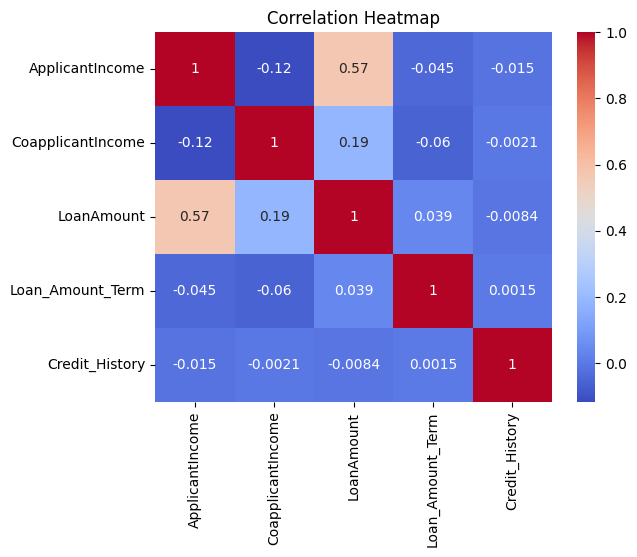

In [5]:
sns.heatmap(loan_dataset[['ApplicantIncome', 'CoapplicantIncome', 
                          'LoanAmount', 'Loan_Amount_Term', 
                          'Credit_History']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [6]:
# Dataset first 5 rows
loan_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
# Statistical measures
loan_dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
# Values of categorical columns
for col in ['Gender', 'Married', 'Dependents',
            'Education', 'Self_Employed', 
            'Property_Area', 'Loan_Status']:
    print(f"{col}: {loan_dataset[col].unique()}")
# number of missing values in each column
loan_dataset.isnull().sum()

Gender: ['Male' 'Female' nan]
Married: ['No' 'Yes' nan]
Dependents: ['0' '1' '2' '3+' nan]
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes' nan]
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: ['Y' 'N']


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
# Values of categorical columns
for col in ['Gender', 'Married', 'Dependents', 
            'Education', 'Self_Employed', 'Property_Area', 
            'Loan_Status']:
    print(f"{col}: {loan_dataset[col].unique()}")

Gender: ['Male' 'Female' nan]
Married: ['No' 'Yes' nan]
Dependents: ['0' '1' '2' '3+' nan]
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes' nan]
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: ['Y' 'N']


In [10]:
# 1. Standardize and clean the 'Dependents' column
loan_dataset['Dependents'] = loan_dataset['Dependents'].replace('3+', '3')  # Replace '3+' with '3'
loan_dataset['Dependents'] = pd.to_numeric(loan_dataset['Dependents'], 
                                           errors='coerce')  # Convert to numeric
mode_value = loan_dataset['Dependents'].mode()[0]  # Get most frequent value
loan_dataset['Dependents'].fillna(mode_value, 
                                  inplace=True)  # Fill missing dependents with mode

# 2. Handle missing values in categorical columns (excluding 'Gender' and 'Credit_History')
categorical_cols = ['Married', 'Self_Employed', 
                    'Education', 'Property_Area']

for col in categorical_cols:
    mode_val = loan_dataset[col].mode()[0]
    loan_dataset[col].fillna(mode_val, inplace=True)

# 3. Handle missing values in numerical columns
# Use mean for LoanAmount and median for Loan_Amount_Term to handle outliers
loan_dataset['LoanAmount'].fillna(loan_dataset['LoanAmount'].mean(),
                                  inplace=True)
loan_dataset['Loan_Amount_Term'].fillna(loan_dataset['Loan_Amount_Term'].median(),
                                        inplace=True)

# 4. Check final missing values
print("Remaining missing values per column:\n", loan_dataset.isnull().sum())
loan_dataset.dropna(inplace=True)


Remaining missing values per column:
 Loan_ID               0
Gender               13
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


C:\Users\rachi\AppData\Local\Temp\ipykernel_21716\2930781135.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_dataset['Dependents'].fillna(mode_value,
C:\Users\rachi\AppData\Local\Temp\ipykernel_21716\2930781135.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [11]:
loan_dataset.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### __Feature Engineering__

In [12]:
loan_dataset['Total_Income'] = loan_dataset['ApplicantIncome'] + loan_dataset['CoapplicantIncome']
loan_dataset['Total_Income_log'] = np.log(loan_dataset['Total_Income'] + 1)
loan_dataset['LoanAmount_log'] = np.log(loan_dataset['LoanAmount'] + 1)
loan_dataset['Loan_Amount_Term_Years'] = loan_dataset['Loan_Amount_Term'] / 12.0
loan_dataset['Income_to_Loan'] = loan_dataset['Total_Income'] / (loan_dataset['LoanAmount'] + 1)
loan_dataset['Income_to_Loan_log'] = np.log(loan_dataset['Total_Income'] / (loan_dataset['LoanAmount'] + 1))

### __Data Visualization to understand relation__ 


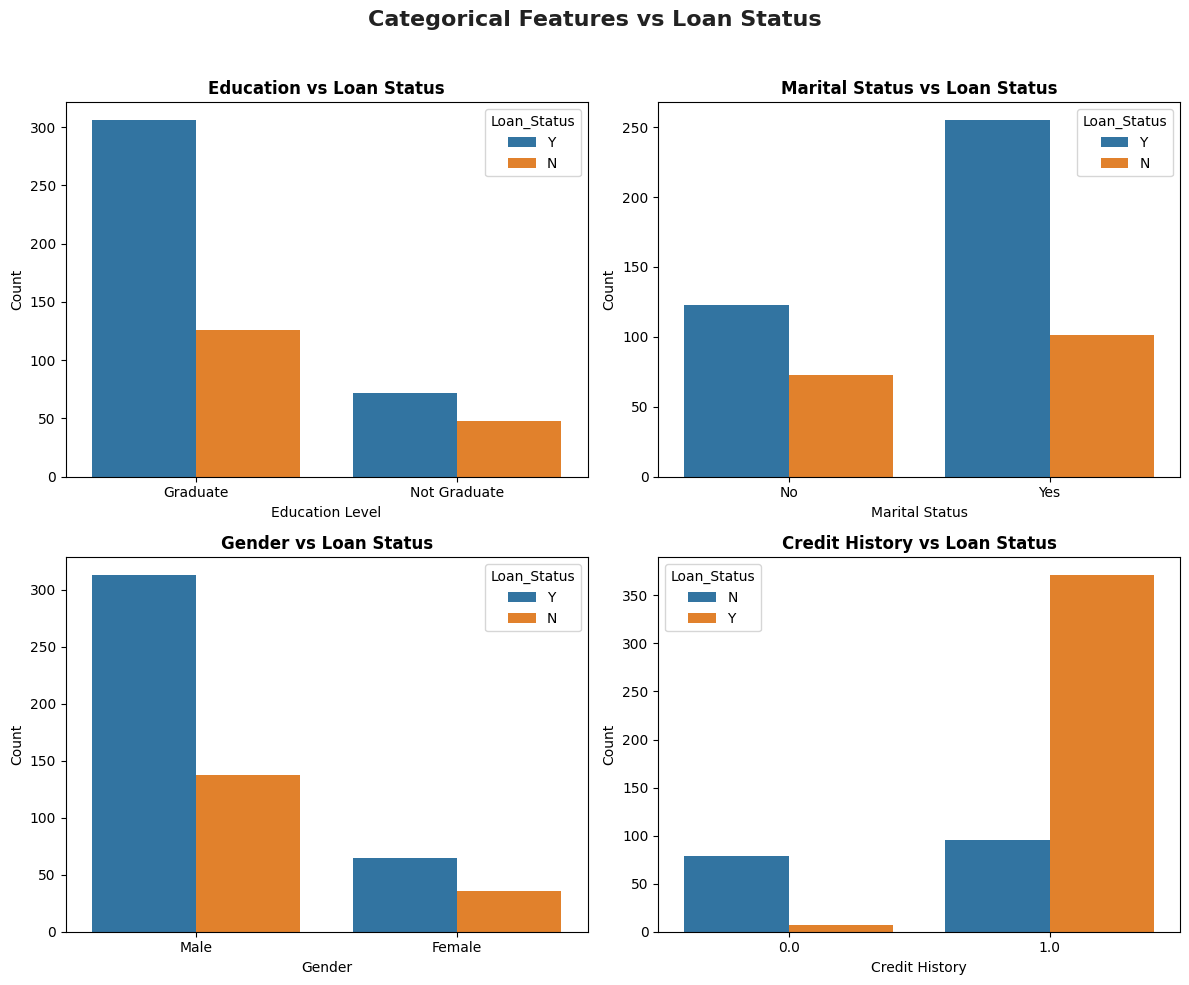

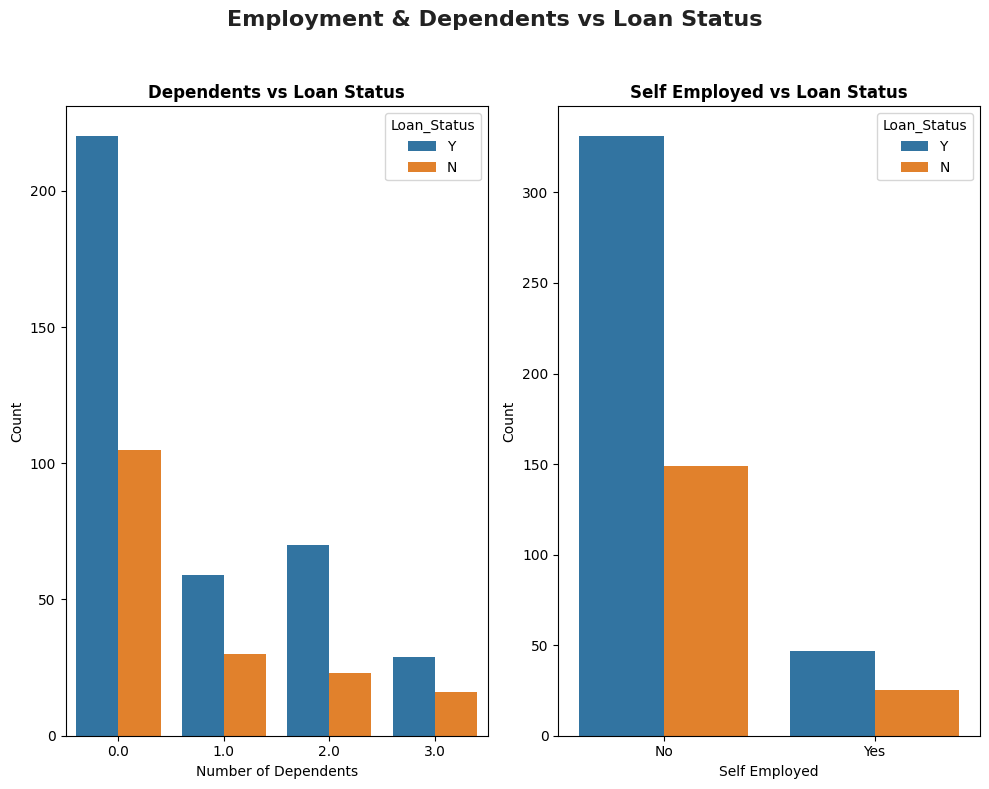

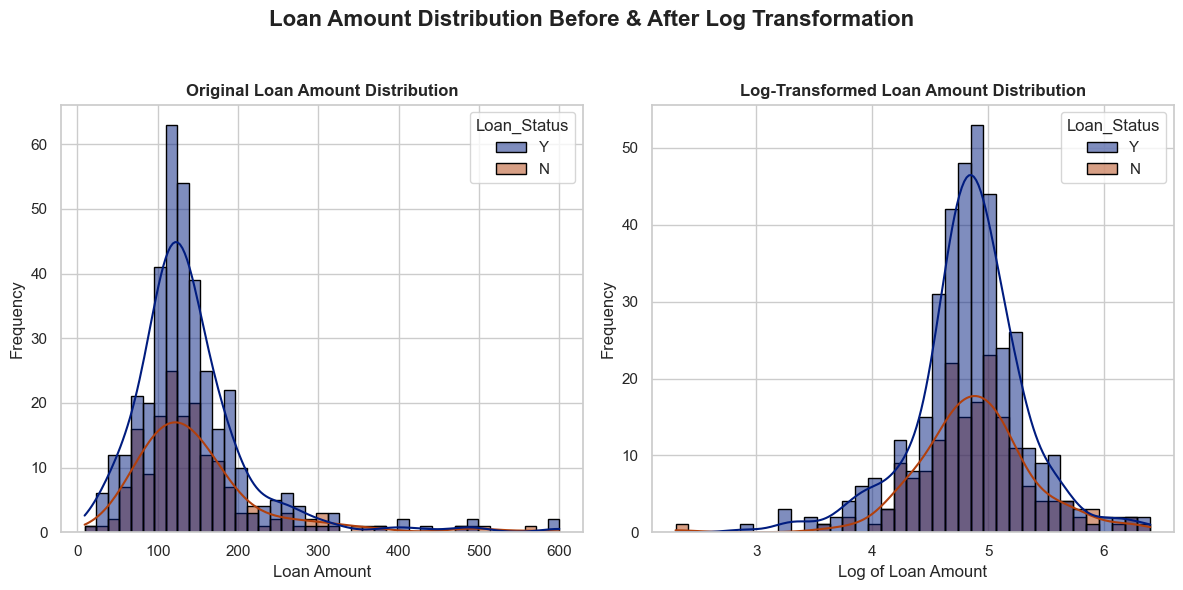

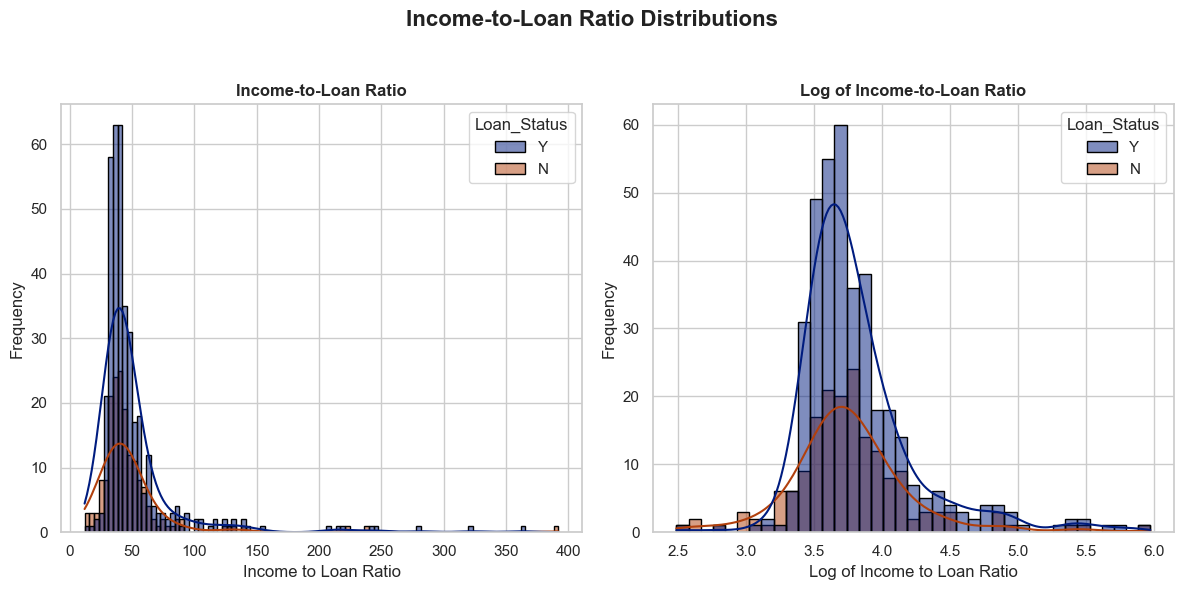

In [13]:
# 1️. Categorical Variables vs Loan Status
plt.figure(figsize=(12, 10))
plt.suptitle("Categorical Features vs Loan Status", fontsize=16, fontweight='bold', color='#222222')

# Education
plt.subplot(2, 2, 1)
sns.countplot(x="Education", hue="Loan_Status", data=loan_dataset)
plt.title("Education vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Education Level")
plt.ylabel("Count")

# Marital Status
plt.subplot(2, 2, 2)
sns.countplot(x="Married", hue="Loan_Status", data=loan_dataset)
plt.title("Marital Status vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Marital Status")
plt.ylabel("Count")

# Gender
plt.subplot(2, 2, 3)
sns.countplot(x="Gender", hue="Loan_Status", data=loan_dataset)
plt.title("Gender vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Gender")
plt.ylabel("Count")

# Credit History
plt.subplot(2, 2, 4)
sns.countplot(x="Credit_History", hue="Loan_Status", data=loan_dataset)
plt.title("Credit History vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Credit History")
plt.ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2️. Employment & Dependents vs Loan Status

plt.figure(figsize=(10, 8))
plt.suptitle("Employment & Dependents vs Loan Status", fontsize=16, fontweight='bold', color='#222222')
# Dependents
plt.subplot(1, 2, 1)
sns.countplot(x="Dependents", hue="Loan_Status", data=loan_dataset)
plt.title("Dependents vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Number of Dependents")
plt.ylabel("Count")

# Self Employed
plt.subplot(1, 2, 2)
sns.countplot(x="Self_Employed", hue="Loan_Status", data=loan_dataset)
plt.title("Self Employed vs Loan Status", fontsize=12, fontweight='bold')
plt.xlabel("Self Employed")
plt.ylabel("Count")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------------------------------
# DARKER HISTOGRAMS FOR NUMERIC FEATURES
# ------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="deep")  # Base dark palette

# ============================
# Loan Amount Distributions (Before & After Log Transform)
# ============================
plt.figure(figsize=(12, 6))
plt.suptitle("Loan Amount Distribution Before & After Log Transformation",
             fontsize=16, fontweight='bold', color='#222222')

# Original Loan Amount
plt.subplot(1, 2, 1)
sns.histplot(
    data=loan_dataset, x="LoanAmount", hue="Loan_Status",
    kde=True, alpha=0.5, edgecolor='black', linewidth=1.0,
    palette="dark"
)
plt.title("Original Loan Amount Distribution", fontsize=12, fontweight='bold')
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")

# Log-transformed Loan Amount
plt.subplot(1, 2, 2)
sns.histplot(
    data=loan_dataset, x="LoanAmount_log", hue="Loan_Status",
    kde=True, alpha=0.5, edgecolor='black', linewidth=1.0,
    palette="dark"
)
plt.title("Log-Transformed Loan Amount Distribution", fontsize=12, fontweight='bold')
plt.xlabel("Log of Loan Amount")
plt.ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ============================
# Income-to-Loan Ratio Visualization
# ============================
plt.figure(figsize=(12, 6))
plt.suptitle("Income-to-Loan Ratio Distributions",
             fontsize=16, fontweight='bold', color='#222222')

# Raw Income-to-Loan Ratio
plt.subplot(1, 2, 1)
sns.histplot(
    data=loan_dataset, x="Income_to_Loan", hue="Loan_Status",
    kde=True, alpha=0.5, edgecolor='black', linewidth=1.0,
    palette="dark"
)
plt.title("Income-to-Loan Ratio", fontsize=12, fontweight='bold')
plt.xlabel("Income to Loan Ratio")
plt.ylabel("Frequency")

# Log-transformed Income-to-Loan Ratio
plt.subplot(1, 2, 2)
sns.histplot(
    data=loan_dataset, x="Income_to_Loan_log", hue="Loan_Status",
    kde=True, alpha=0.5, edgecolor='black', linewidth=1.0,
    palette="dark"
)
plt.title("Log of Income-to-Loan Ratio", fontsize=12, fontweight='bold')
plt.xlabel("Log of Income to Loan Ratio")
plt.ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [14]:
loan_dataset.shape

(552, 19)

__Label Encoding__

In [15]:
# label encoding of categorical data to numerical data
loan_dataset = loan_dataset.replace({"Married":{"No": 0, "Yes": 1},
                                     "Gender": {"Male": 1, "Female": 0},
                                     "Self_Employed": {"No": 0, "Yes": 1},
                                     "Property_Area": {"Rural": 0, "Semiurban": 1, "Urban": 2},
                                     "Education": {"Graduate": 1, "Not Graduate": 0},
                                     "Loan_Status": {'N': 0, 'Y': 1}
                                     })


C:\Users\rachi\AppData\Local\Temp\ipykernel_21716\1841722457.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_dataset = loan_dataset.replace({"Married":{"No": 0, "Yes": 1},


In [16]:
loan_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Total_Income_log,LoanAmount_log,Loan_Amount_Term_Years,Income_to_Loan,Income_to_Loan_log
0,LP001002,1,0,0.0,1,0,5849,0.0,146.412162,360.0,1.0,2,1,5849.0,8.674197,4.993232,30.0,39.677866,3.680793
1,LP001003,1,1,1.0,1,0,4583,1508.0,128.000000,360.0,1.0,0,0,6091.0,8.714732,4.859812,30.0,47.217054,3.854755
2,LP001005,1,1,0.0,1,1,3000,0.0,66.000000,360.0,1.0,2,1,3000.0,8.006701,4.204693,30.0,44.776119,3.801675
3,LP001006,1,1,0.0,0,0,2583,2358.0,120.000000,360.0,1.0,2,1,4941.0,8.505525,4.795791,30.0,40.834711,3.709532
4,LP001008,1,0,0.0,1,0,6000,0.0,141.000000,360.0,1.0,2,1,6000.0,8.699681,4.955827,30.0,42.253521,3.743688


In [17]:
# Separating data and label
X = loan_dataset.drop(columns=["Loan_ID", "Loan_Status"], axis=1) 
Y = loan_dataset['Loan_Status']


### __Model Training__


In [18]:
## Train Test Split for splitting data into two portions 
# X_train: training features data for model training
# X_test: testing features data for model testing
# Y_train: training target data for model training
# Y_test: testing target data for model testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, stratify=Y,
                                                    random_state=2)
print(f" Training data shape: {X_train.shape}\n Testing data shape: {X_test.shape}")

 Training data shape: (441, 17)
 Testing data shape: (111, 17)


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
## Training model using support vector machine SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='precision', n_jobs=-1)
grid.fit(X_train_scaled, Y_train)

print(grid.best_params_)
print(grid.best_score_)

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
0.8315226132826012


In [32]:
classifier = SVC(C=0.1, class_weight='balanced', kernel='rbf', gamma='scale')
classifier.fit(X_train_scaled, Y_train)

SVC(C=0.1, class_weight='balanced')

### __Model Evaluation__

In [33]:
# accuracy score on training 
X_train_prediction = classifier.predict(X_train_scaled)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
training_data_precision = precision_score(X_train_prediction, Y_train)
training_data_f1_score = f1_score(X_train_prediction, Y_train)
training_data_recall_score = recall_score(X_train_prediction, Y_train)
print('Accuracy Score on training data: ', training_data_accuracy)
print('Precision Score on training data: ', training_data_precision)
print('F1 Score on training data: ', training_data_f1_score)
print('Recall Score on training data: ', training_data_recall_score)


# accuracy score on testing
X_test_prediction = classifier.predict(X_test_scaled)
testing_data_accuracy = accuracy_score(X_test_prediction, Y_test)
testing_data_precision = precision_score(X_test_prediction, Y_test)
testing_data_f1_score = f1_score(X_test_prediction, Y_test)
testing_data_recall_score = recall_score(X_test_prediction, Y_test)
print('Accuracy Score on testing data: ', testing_data_accuracy)
print('Precision Score on testing data: ', testing_data_precision)
print('F1 Score on testing data: ', testing_data_f1_score)
print('Recall Score on testing data: ', testing_data_recall_score)

Accuracy Score on training data:  0.7709750566893424
Precision Score on training data:  0.8278145695364238
F1 Score on training data:  0.831946755407654
Recall Score on training data:  0.8361204013377926
Accuracy Score on testing data:  0.7387387387387387
Precision Score on testing data:  0.8421052631578947
F1 Score on testing data:  0.8152866242038217
Recall Score on testing data:  0.7901234567901234


### __Saving Model for future use__

In [34]:
# Saving model using joblib
model_filename = 'loan_prediction_model.pkl'
joblib.dump(classifier, open('artefacts/loan_prediction_model.pkl', 'wb'))
# Saving scaler using joblib
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, open('artefacts/scaler.pkl', 'wb'))

Model Evaluation Metrics:
Accuracy Score     : 0.7387
Precision Score    : 0.7901
Recall Score       : 0.8421
F1-Score           : 0.8153

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.51      0.55        35
           1       0.79      0.84      0.82        76

    accuracy                           0.74       111
   macro avg       0.70      0.68      0.68       111
weighted avg       0.73      0.74      0.73       111



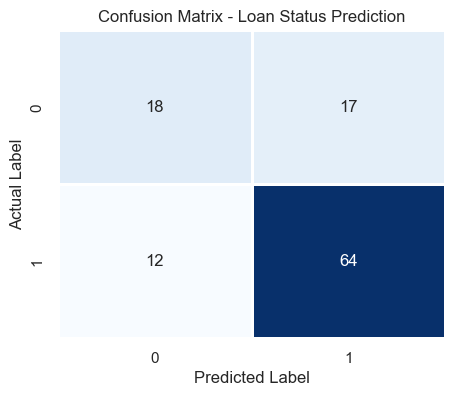

In [35]:
# Import required libraries
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, 
                             classification_report)
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using trained model
Y_pred = classifier.predict(X_test_scaled)

# --- Evaluation Metrics ---
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy Score     : {accuracy:.4f}")
print(f"Precision Score    : {precision:.4f}")
print(f"Recall Score       : {recall:.4f}")
print(f"F1-Score           : {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1)
plt.title("Confusion Matrix - Loan Status Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [25]:
loan_dataset.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Total_Income_log,LoanAmount_log,Loan_Amount_Term_Years,Income_to_Loan,Income_to_Loan_log
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,0.817029,0.644928,0.742754,0.782609,0.130435,5345.682971,1536.597681,143.671477,342.652174,0.844203,1.032609,0.684783,6882.280652,8.659132,4.857835,28.554348,50.769411,3.801101
std,0.386993,0.478969,1.009457,0.412845,0.337087,5940.111552,2487.874356,78.216074,64.088715,0.362992,0.784853,0.465024,6163.101263,0.533469,0.486188,5.340726,38.072193,0.436138
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000,1442.000000,7.274480,2.302585,3.000000,12.042969,2.488481
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2892.750000,0.000000,100.750000,360.000000,1.000000,0.000000,0.000000,4158.250000,8.333090,4.622510,30.000000,35.027930,3.556146
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3815.000000,1105.500000,128.000000,360.000000,1.000000,1.000000,1.000000,5359.000000,8.586707,4.859812,30.000000,41.112921,3.716322
75%,1.000000,1.000000,1.250000,1.000000,0.000000,5739.500000,2253.250000,161.250000,360.000000,1.000000,2.000000,1.000000,7451.500000,8.916305,5.089135,30.000000,50.647147,3.924882
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000,81000.000000,11.302217,6.398595,40.000000,392.010989,5.971290
